In [ ]:
! pip install pillow

In [ ]:
!sudo apt install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


#OCR
In order to work with OCR the first step os to get the picture. One of the library which can be used is “Pillow”. Here is some useful funcetions from the mentioned library :


In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import pytesseract

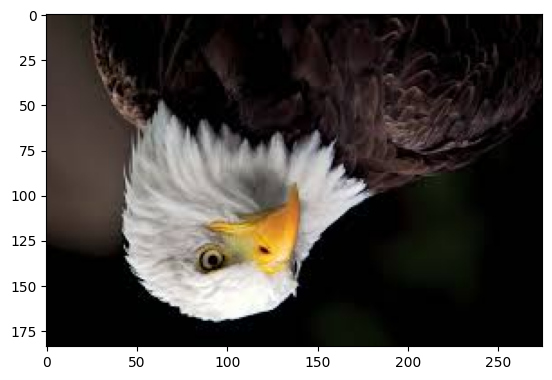

In [ ]:
pic = Image.open("/content/Eagle.jpg")
pic  = pic.rotate(180)
plt.imshow(pic)
pic.save("/content/pic.png")

In [ ]:
def display(im_data):

    dpi = 80
    height, width, depth = im_data.shape

    # What size does the figure need to be in inches to fit the image?
    figsize = width / float(dpi), height / float(dpi)

    # Create a figure of the right size with one axes that takes up the full figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])

    # Hide spines, ticks, etc.
    ax.axis('off')

    # Display the image.
    ax.imshow(im_data, cmap='gray')

    plt.show()
def display_grey(im_data ):
  plt.figure(figsize=(30, 15))

  for img in range(len(im_data)) :

    plt.subplot(   1 , len(im_data) ,img+1)
    plt.imshow(im_data[img] , cmap='gray')
    plt.axis('off')
  plt.show()



## Preprocessing
It can be done using Open CV. it has several steps that will be discussing in the follwing boxes.
### Inverting
As you see in the code belo the color of the picture has been inverted.

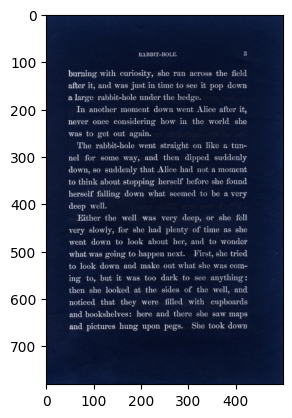

In [ ]:
import cv2
pic = cv2.imread("/content/Alice-In-Wonderland-Book-Page-3-Old-Design-Shop-500x781.jpg")
pic = cv2.cvtColor(pic, cv2.COLOR_BGR2RGB)
inverted_pic = cv2.bitwise_not(pic)
plt.imshow(inverted_pic)

## Rescaling

## Binerization
Firstly the picture should be converted to garyscale .
one of the approaches for binerization is using threshholding. its documention can be found in the link below:
https://docs.opencv.org/4.x/d7/d4d/tutorial_py_thresholding.html

In [ ]:
import cv2
pic = cv2.imread("/content/OCR.jpg")
gray_pic = cv2.cvtColor(pic, cv2.COLOR_BGR2GRAY)


Here we test som of binerization.


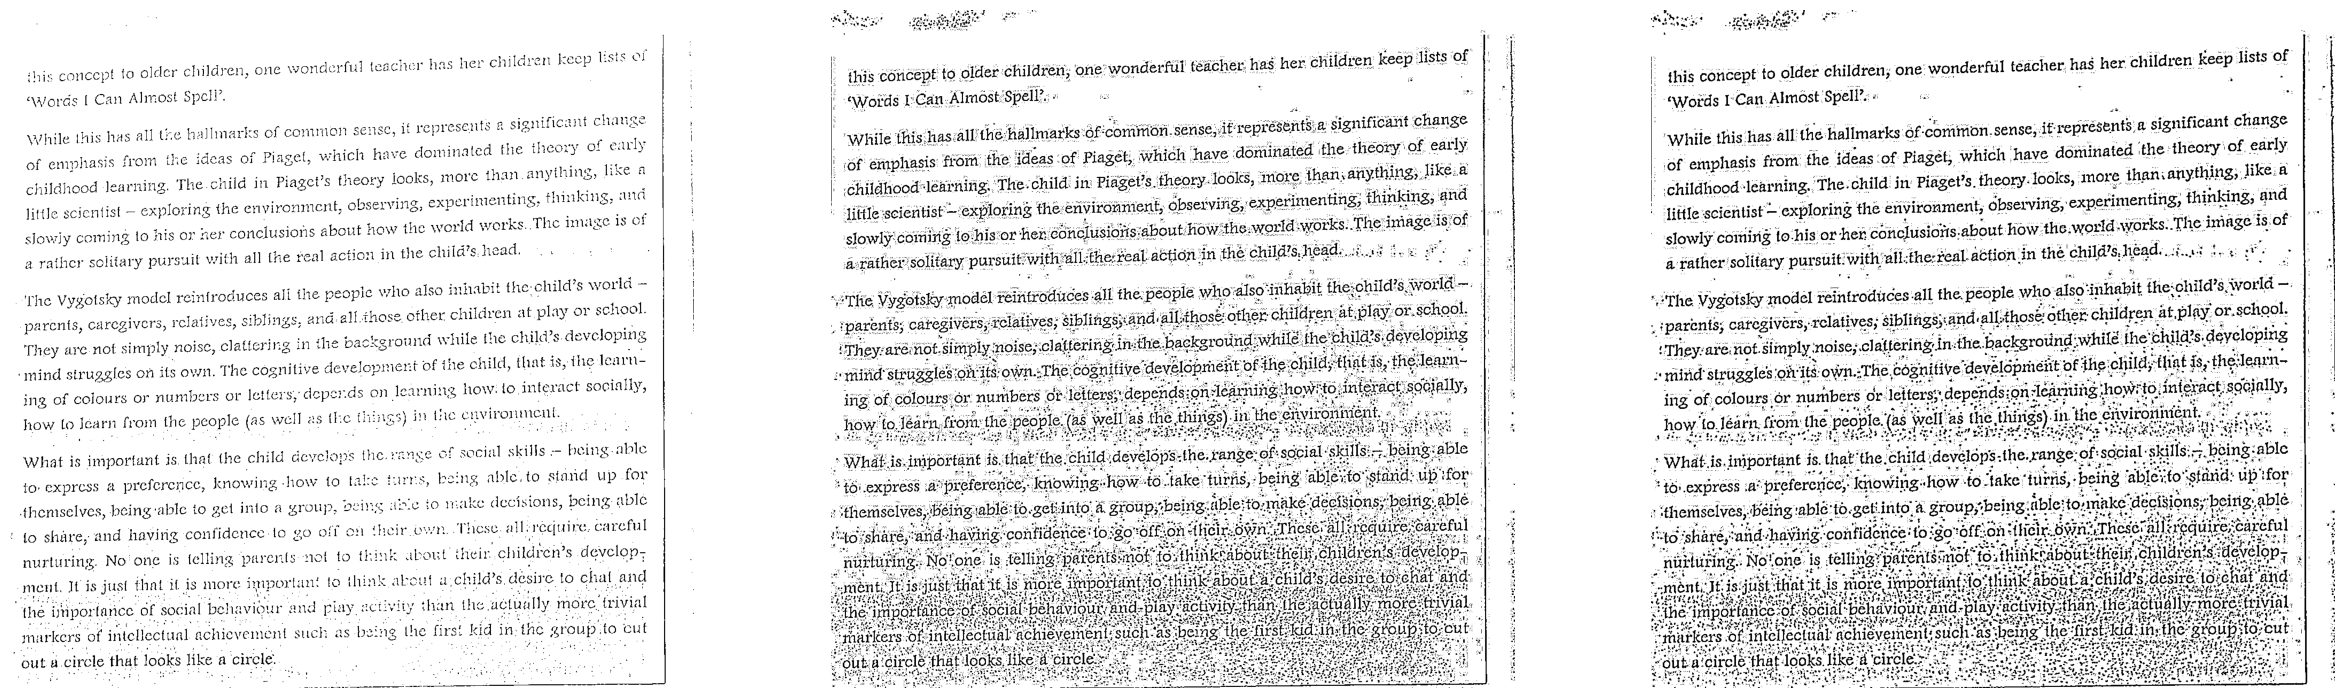

In [ ]:
images= []
ret1 , tresh1 = cv2.threshold(gray_pic , 127 , 255 , cv2.THRESH_BINARY)
tresh2 = cv2.adaptiveThreshold(gray_pic , 255 , cv2.ADAPTIVE_THRESH_GAUSSIAN_C , cv2.THRESH_BINARY , 11 , 2)
tresh3 = cv2.adaptiveThreshold(gray_pic , 255 , cv2.ADAPTIVE_THRESH_MEAN_C , cv2.THRESH_BINARY , 11 , 2)

images.append(tresh1)
images.append(tresh2)
images.append(tresh3)

display_grey(images )

## Remove the noises
The first point is erosion and dilation : \\
### Erosion:
 Erosion removes pixels on object boundaries. A pixel in the original image (either 1 or 0) will be considered 1 only if all the pixels under the kernel are 1, otherwise it is eroded (made to zero).

This operation is useful for removing small white noises, detach two connected objects, etc.

###  Dilation:
 Dilation adds pixels to the boundaries of objects in an image. A pixel element in the original image is ‘1’ if at least one pixel under the kernel is ‘1’.

This operation is useful for joining broken parts of an object, increasing the size of the object, etc.

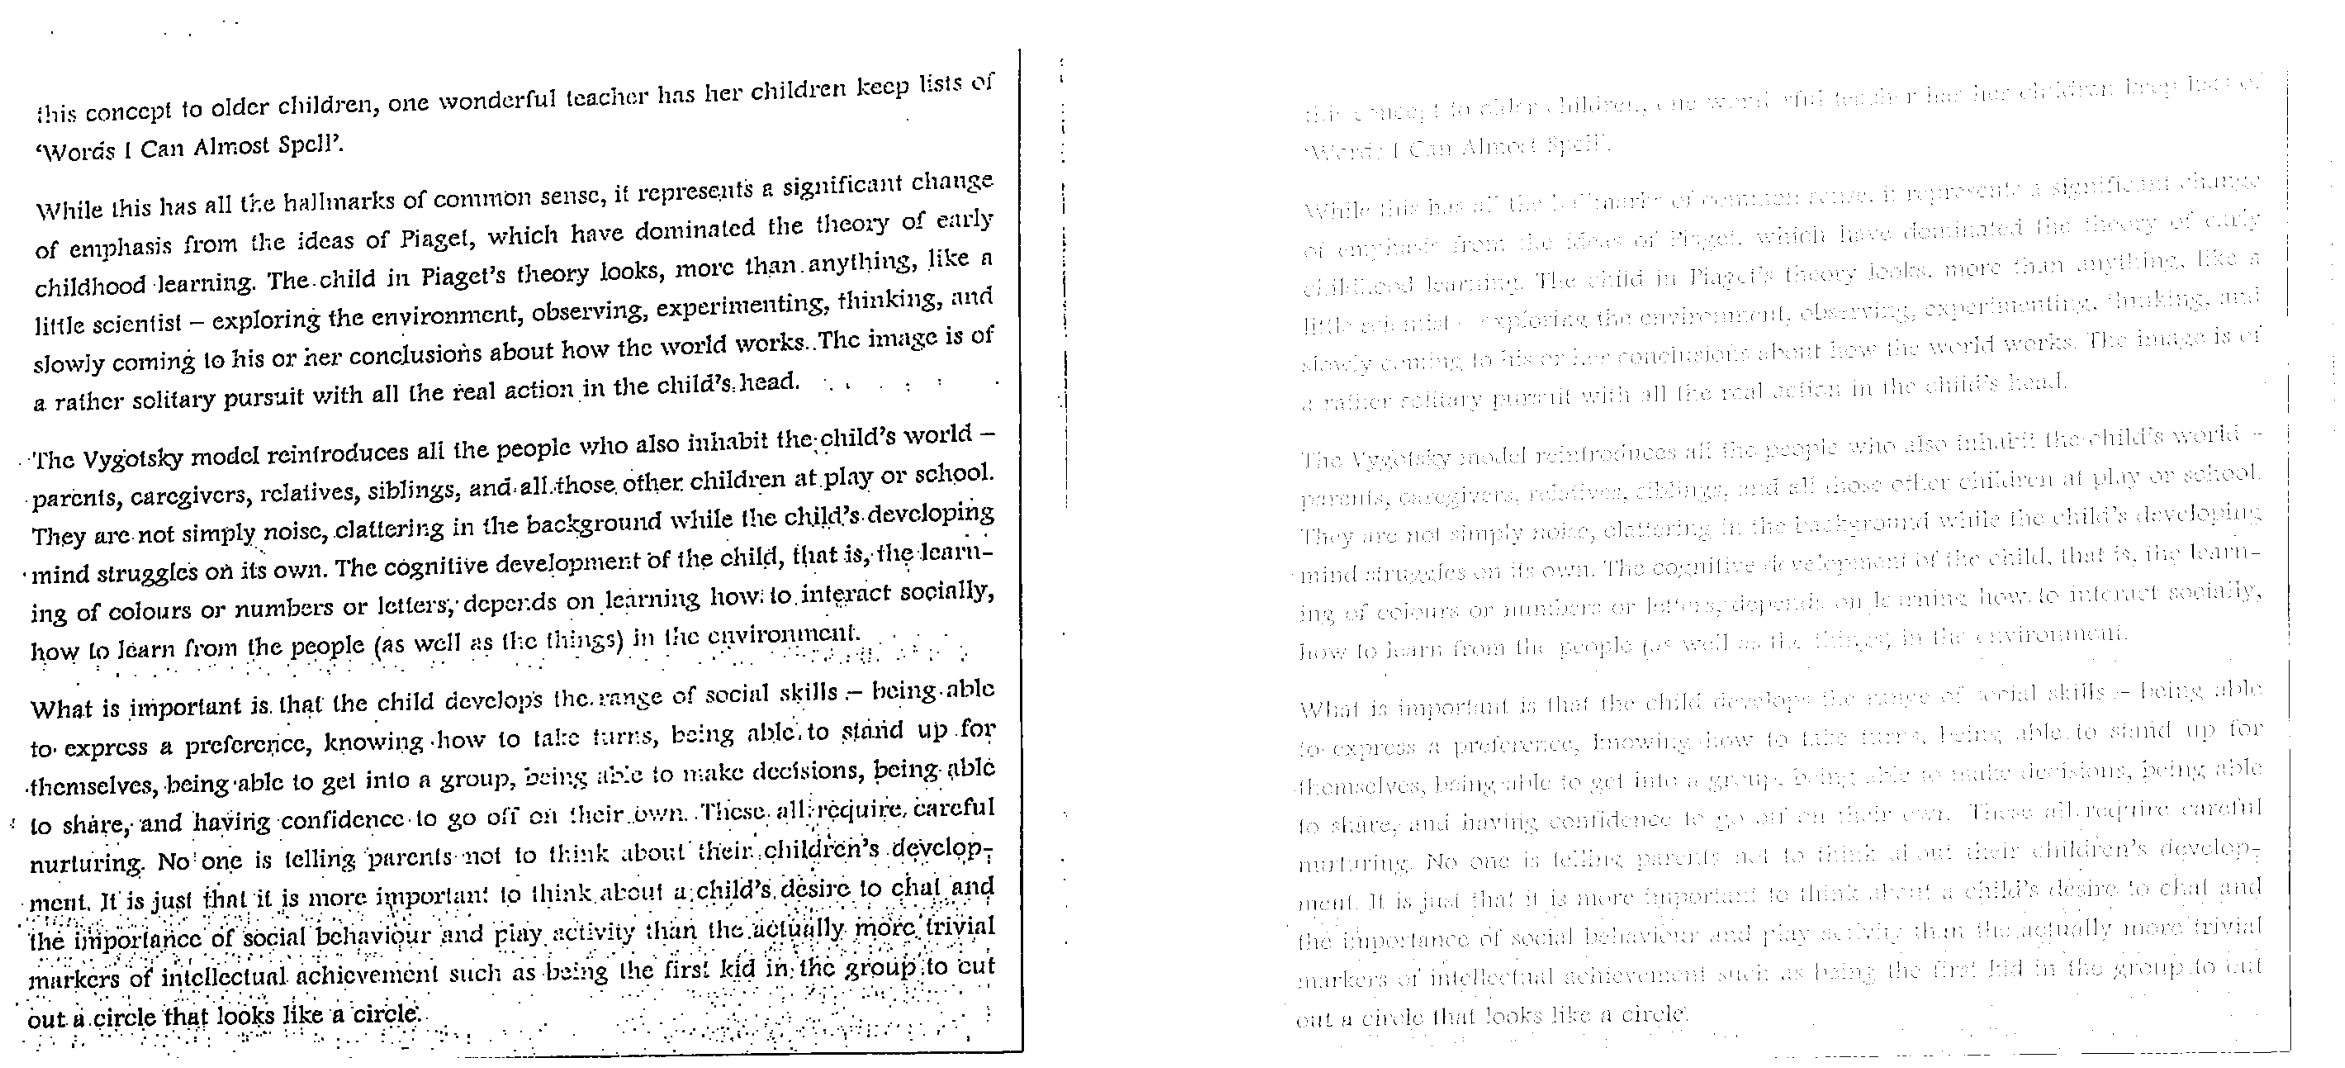

In [ ]:
import numpy as np
kernel = np.ones((2,2),np.uint8)

pic1 = cv2.erode(tresh1 , kernel , iterations = 1)
pic2 = cv2.dilate(tresh1 , kernel , iterations = 1)

images = []
images.append(pic1)
images.append(pic2)
display_grey(images)


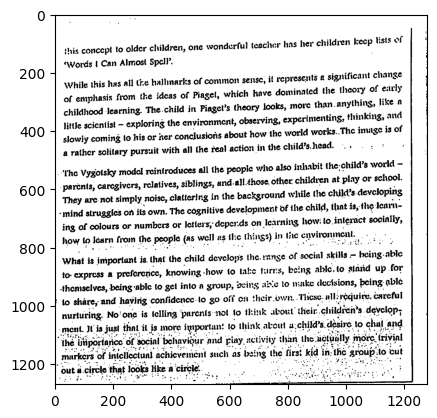

In [ ]:
pic3 = cv2.GaussianBlur(pic1 , (3,3) , 0)
ren , pic3 = cv2.threshold(pic3 , 200 , 255 , cv2.THRESH_BINARY)
plt.imshow(pic3 , cmap='gray')

In [ ]:
# using fft inorder to reduce the noise
import numpy as np
import cv2

def fft(img):
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = 20 * np.log(np.abs(fshift))
    return fshift

def coefficient_adjustment(fft_image, coefficient):
    height, width = fft_image.shape
    fft_image[0:int(height*coefficient), 0:width] = 0
    fft_image[:, -int(width*coefficient):] = 0
    fft_image[-int(height*coefficient):, :] = 0
    fft_image[:, 0:int(width*coefficient)] = 0
    return fft_image

def inverse_fourier_transform(fn, coefficient):
    magnitude = np.abs(fn)
    magnitude = coefficient_adjustment(magnitude, coefficient)
    phase = np.angle(fn)

    real = np.cos(phase) * magnitude
    imag = np.sin(phase) * magnitude
    fft = real + (1j * imag)
    image = np.fft.ifft2(np.fft.ifftshift(fft))
    image = np.real(image)
    image = image.clip(min=0, max=255).astype('uint8')
    return image

def reduce_noise(img, coefficient):
    return inverse_fourier_transform(fft(img), coefficient)



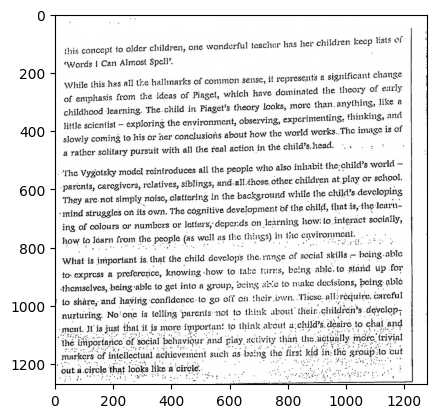

In [ ]:
denoised = reduce_noise(pic1 , 0.1)
plt.imshow(ii , cmap='gray')

In [ ]:
def remove_borders(image):
    contours, hierarchy = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cntSorted = sorted(contours, key=lambda x: cv2.contourArea(x))
    cnt = cntSorted[-1]
    x, y, w, h = cv2.boundingRect(cnt)
    crop = image[y:y+h, x:x+w]
    return crop

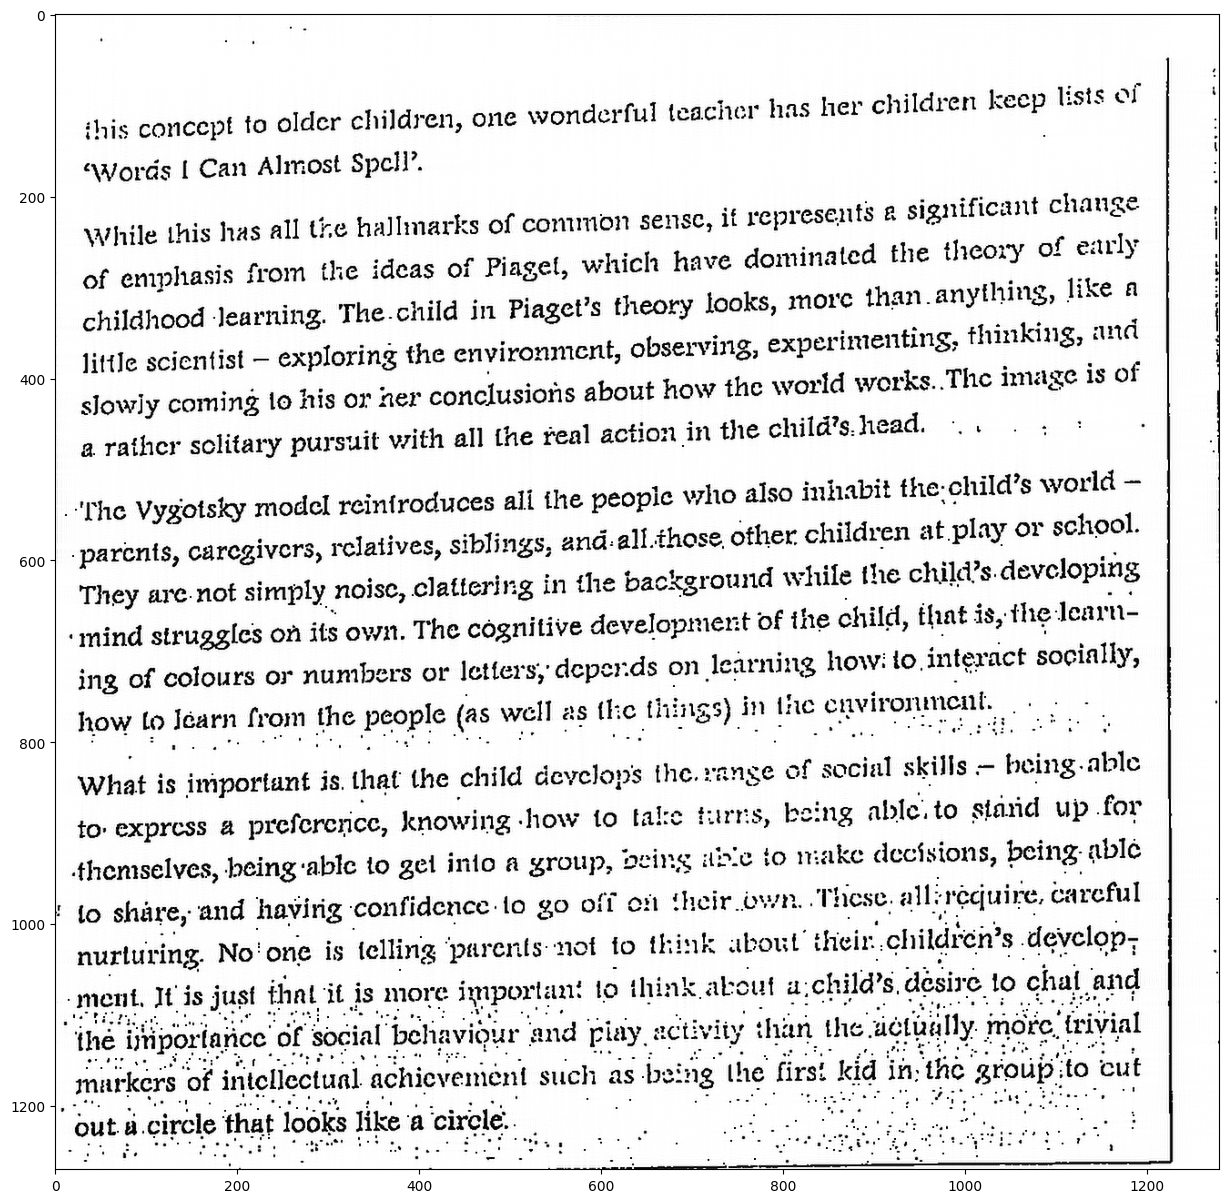

In [ ]:
pic4 = remove_borders(denoised)
plt.figure(figsize=(30, 15))
plt.imshow(pic4 , cmap='gray')

## Deskew a text image
This function has been used from :https://becominghuman.ai/how-to-automatically-deskew-straighten-a-text-image-using-opencv-a0c30aed83df

In [ ]:
# Calculate skew angle of an image
def getSkewAngle(cvImage) -> float:
    # Prep image, copy, convert to gray scale, blur, and threshold
    newImage = cvImage.copy()
    # gray = cv2.cvtColor(newImage, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(newImage, (9, 9), 0)
    thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    # Apply dilate to merge text into meaningful lines/paragraphs.
    # Use larger kernel on X axis to merge characters into single line, cancelling out any spaces.
    # But use smaller kernel on Y axis to separate between different blocks of text
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (30, 5))
    dilate = cv2.dilate(thresh, kernel, iterations=5)

    # Find all contours
    contours, hierarchy = cv2.findContours(dilate, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key = cv2.contourArea, reverse = True)

    # Find largest contour and surround in min area box
    largestContour = contours[0]
    minAreaRect = cv2.minAreaRect(largestContour)

    # Determine the angle. Convert it to the value that was originally used to obtain skewed image
    angle = minAreaRect[-1]
    if angle < -45:
        angle = 90 + angle
    return -1.0 * angle

  # Rotate the image around its center
def rotateImage(cvImage, angle: float):
    newImage = cvImage.copy()
    (h, w) = newImage.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    newImage = cv2.warpAffine(newImage, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return newImage

# Deskew image
def deskew(cvImage):
    angle = getSkewAngle(cvImage)
    return rotateImage(cvImage, -1.0 * angle)

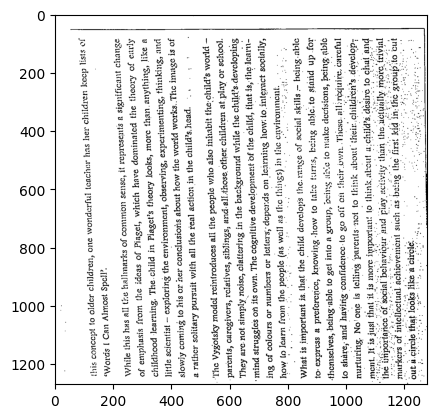

In [ ]:
pic5 = deskew(pic4)
plt.imshow(pic5 , cmap='gray')

In [ ]:
resutlt = pytesseract.image_to_string(pic4)

In [ ]:
print(resutlt)

  
  
 
  
 
 
  
  
 
   
 
 
  
  
 
       
        

this concept to older children, one wonderful teacher has her children keep lists of

“words | Can Almost Spell’.

ensc, if represents & significant change
of emphasis from the ideas of Piaget, which have dominated the theory of early
childhood ‘Jearning. The.child in Piaget’s theory Jooks, more than anything, like a
little scientist — exploring the environment, observing, experimenting, thinking, and
ner conclusions about how the world works..The image is of
on in the child’s.head. -..

While this has all the hallmarks of conmmon 5

slowly coming to his or
a rather sclitary pursuit with all the teal acti

.'The Vygotsky model reintroduces all the peopic who also inhabit the-child’s world —

, siblings, and.all.those, other children at play or school.
round while the child’s.developing
t of the child, that is, the Jearn-

-parents, caregivers, relatives
They are-not simply noise, clattering in the backg.
«mind struggles on its ow